# Detecting Alzheimer's in Elderly Patients budget ass code 💀

In [ ]:
#importing relevant libraries, add more if needed
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
import pandas as pd

import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

In [ ]:
#reading the dataset
df = pd.read_csv("https://raw.githubusercontent.com/AshWz-Uni/CSS2-2025/refs/heads/main/oasis_longitudinal_demographics_data.csv")
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


# Data Exploration
*Exploring the entire dataset before preprocessing*

Data variables:
- `Subject ID`: ID of the subject
- `MRI ID`: ID used for the MRI image (not using since we cant get that to work because god hates me)
- `Group`: If the person had alzheimers **CLASSIFICATION VARIABLE**
- `Visit`: The visit number of the patient
- `MR Delay`: something idk man
- `M/F`: gender
- `Hand`: hand dominance **(not using cause the distribution is too biased)**
- `Age`: age
- `EDUC`: education levels
- `SES`: socieconomic status
- `MMSE`: mini mental state examination
- `CDR`: clinical dementia rating
- `eTIV`: estimated total intracranial volume
- `nWBV`: normalize whole brain volume
- `ASF`: atlas scaling factor

In [ ]:
#hand values are all right handed so we are not using that
df.Hand.value_counts()

Hand
R    373
Name: count, dtype: int64


NOTE: When analysing, ig use `df_copy` instead of `df` since i replaced *Converted* with *Demented* to allow binary classification

* Demented is group 0
* Nondemented is group 1
---






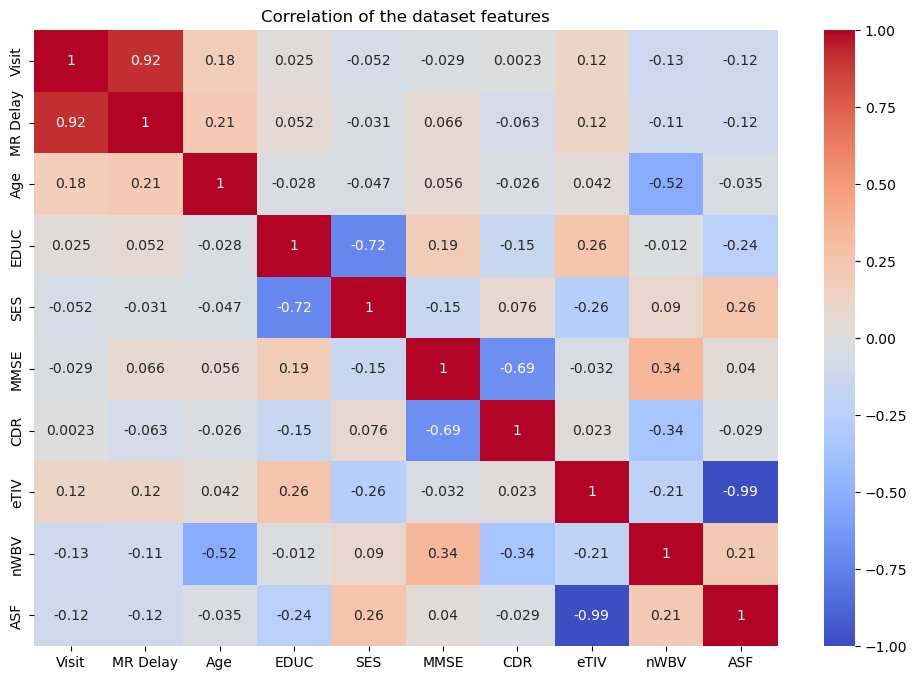

In [ ]:
#preparing the correlation matrix for the dataset
encoder = LabelEncoder()

#replacing the "Converted" value into "Demented" to allow binary classification
df_copy = df.copy()
df_copy['Group'] = df_copy['Group'].replace({'Converted': 'Demented'})
# print(df_copy['Group'].value_counts())
df_copy['Group'] = encoder.fit_transform(df_copy['Group'])
# display(df_copy)


#creating the correlation
df_corr = df_copy.select_dtypes(include=['float64', 'int64'])
corr_matrix = df_corr.corr()

#displaying the correlation
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of the dataset features')
plt.show()

From the correlation matrix, we discovered that the `MMSE` and `nWBV` variables maintains a positive correlation to the class variable, highlighting their impact towards the classification

In [ ]:
print(encoder.classes_)

['Demented' 'Nondemented']


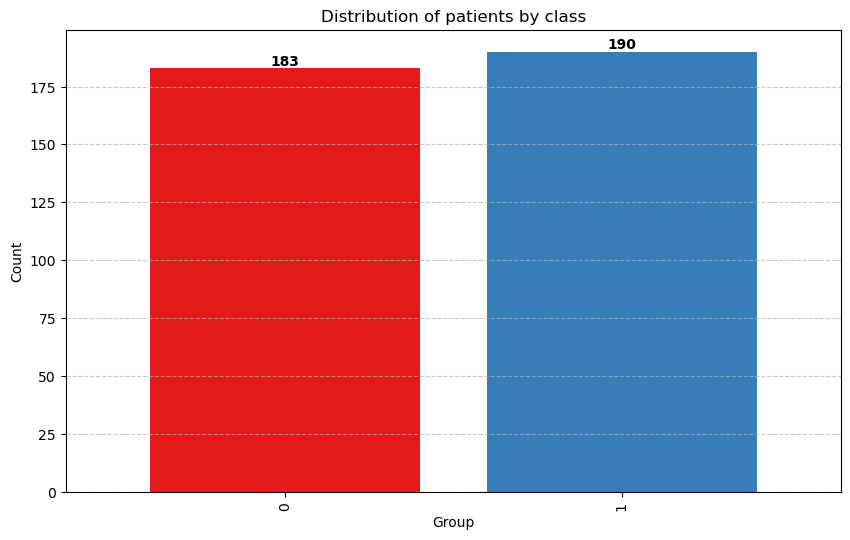

In [ ]:
classes = df_copy.Group.value_counts(ascending=True)

ax = classes.plot(kind='bar', figsize=(10, 6), color=plt.cm.Set1.colors, width=0.8)

for p in ax.patches:
  ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel("Group")
plt.ylabel("Count")
plt.title("Distribution of patients by class")
plt.grid(axis='y', linestyle='--', alpha=0.7)

The class distribution is fairly balanced so idk if we need to balance it more or not using SMOTE.

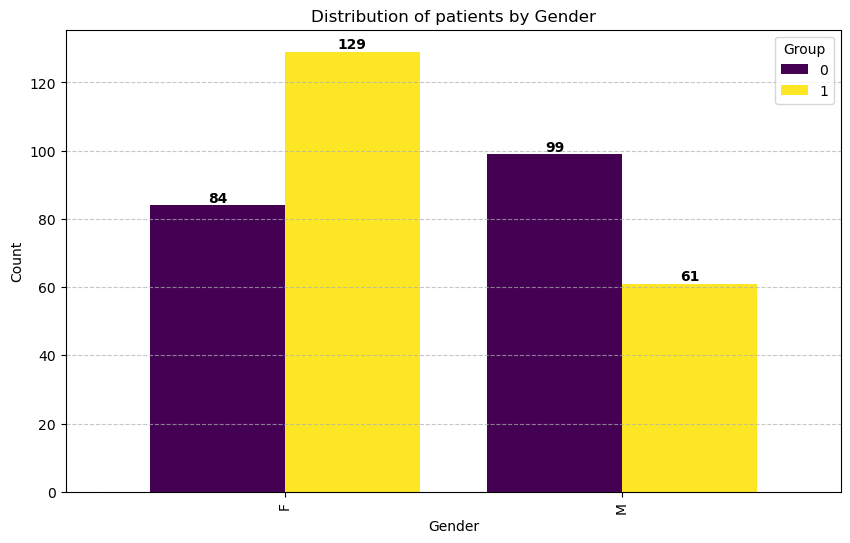

In [ ]:
#bar chart of the gender based on group
gender_counts = df_copy.groupby(['M/F', 'Group']).size().unstack()

ax = gender_counts.plot(kind='bar', figsize=(10, 6), colormap='viridis', width=0.8)

for p in ax.patches:
  ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Distribution of patients by Gender")
plt.legend(title="Group")
plt.grid(axis='y', linestyle='--', alpha=0.7)

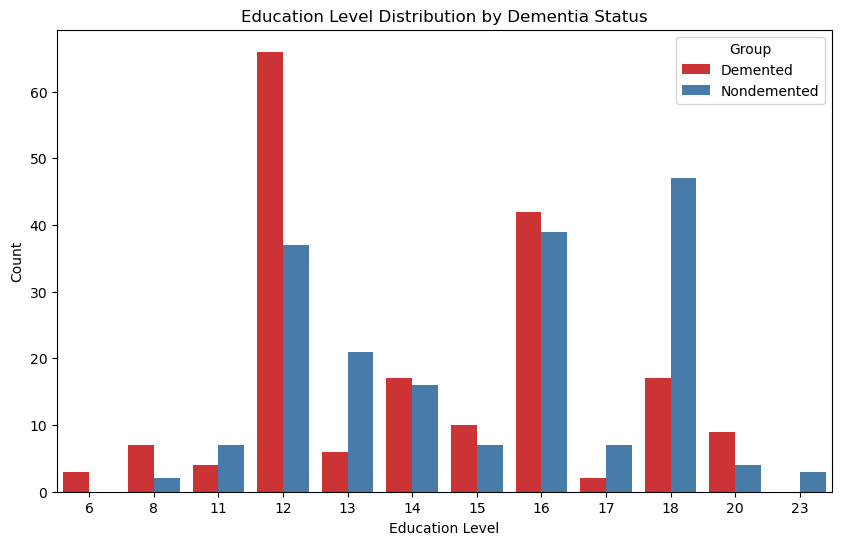

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_copy, x='EDUC', hue='Group', palette='Set1')
plt.title('Education Level Distribution by Dementia Status')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.legend(title='Group', labels = ["Demented", "Nondemented"])
plt.show()

* Large majority of Demented individuals recieved level 12 education
* At level 20, Nondemened count is slightly higher, could suggest higher education does not directly correlate to protection against Dementia



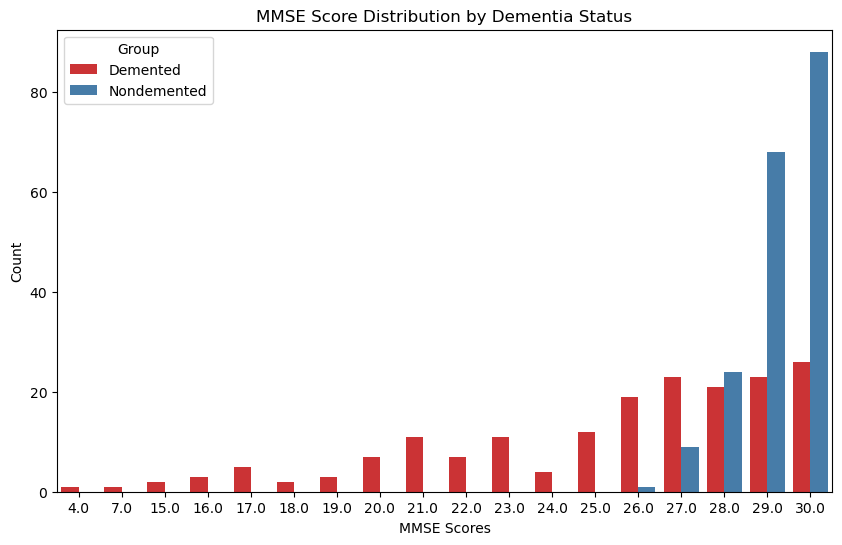

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_copy, x='MMSE', hue='Group', palette='Set1')
plt.title('MMSE Score Distribution by Dementia Status')
plt.xlabel('MMSE Scores')
plt.ylabel('Count')
plt.legend(title='Group', labels = ["Demented", "Nondemented"])
plt.show()

MMSE (Mini Mental State Examination) : Used to assess cognitive function, often used to screen for cognitive impairments; higher is better.
* Nondemented people generally have higher MMSE scores
* Much wider spread for the Demented

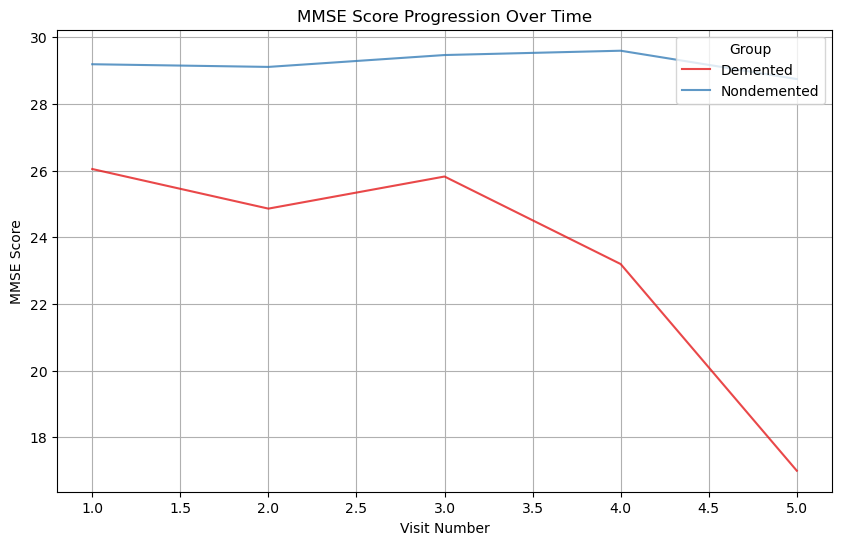

In [ ]:
data_sorted = df_copy[['Subject ID', 'Group', 'Visit', 'MMSE']].sort_values(by=['Subject ID', 'Visit'])

plt.figure(figsize=(10, 6))
sns.lineplot(x='Visit', y='MMSE', hue='Group', data=data_sorted, errorbar=None, alpha=0.8, palette='Set1')
plt.title('MMSE Score Progression Over Time')
plt.xlabel('Visit Number')
plt.ylabel('MMSE Score')
plt.legend(title='Group', loc='upper right', labels = ["Demented", "Nondemented"])
plt.grid(True)
plt.show()

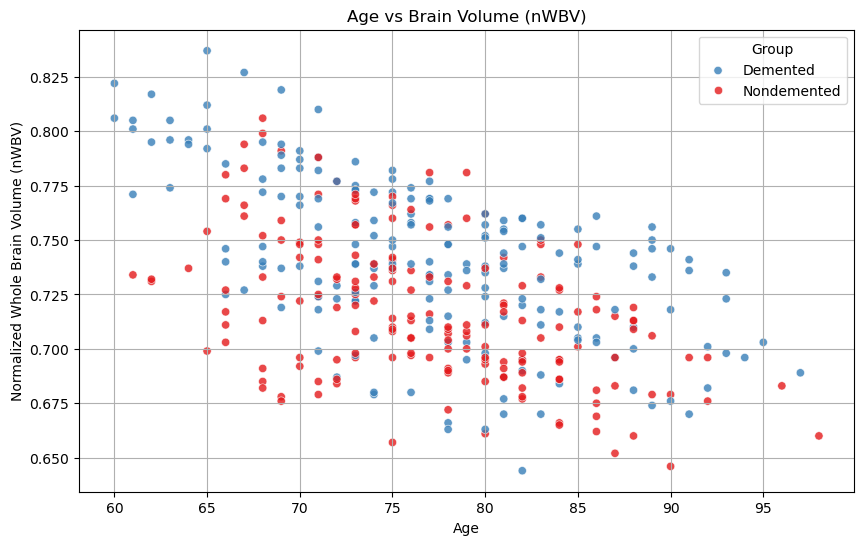

In [ ]:
data_sorted = df_copy[['Age', 'Group', 'nWBV']]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='nWBV', hue='Group', data=data_sorted, alpha=0.8, palette='Set1')
plt.title('Age vs Brain Volume (nWBV)')
plt.xlabel('Age')
plt.ylabel('Normalized Whole Brain Volume (nWBV)')
plt.legend(title='Group', loc='upper right', labels = ["Demented", "Nondemented"])
plt.grid(True)
plt.show()

# Data Preprocessing

In [ ]:
#checking for missing values in the entire dataset
display(df[df.isna().any(axis=1)])

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
10,OAS2_0007,OAS2_0007_MR1,Demented,1,0,M,R,71,16,NaN,28.0,0.5,1357,0.748,1.293
11,OAS2_0007,OAS2_0007_MR3,Demented,3,518,M,R,73,16,NaN,27.0,1.0,1365,0.727,1.286
12,OAS2_0007,OAS2_0007_MR4,Demented,4,1281,M,R,75,16,NaN,27.0,1.0,1372,0.710,1.279
134,OAS2_0063,OAS2_0063_MR1,Demented,1,0,F,R,80,12,NaN,30.0,0.5,1430,0.737,1.228
135,OAS2_0063,OAS2_0063_MR2,Demented,2,490,F,R,81,12,NaN,27.0,0.5,1453,0.721,1.208
207,OAS2_0099,OAS2_0099_MR1,Demented,1,0,F,R,80,12,NaN,27.0,0.5,1475,0.762,1.190
208,OAS2_0099,OAS2_0099_MR2,Demented,2,807,F,R,83,12,NaN,23.0,0.5,1484,0.750,1.183


In [ ]:
encoder = LabelEncoder()

#encoding the necessary values for the correct data types
df['Group'] = df['Group'].replace({'Converted': 'Demented'})
df['Group'] = encoder.fit_transform(df['Group'])
df["Subject ID"] = encoder.fit_transform(df["Subject ID"])
df["MRI ID"] = encoder.fit_transform(df["MRI ID"])
df["M/F"] = encoder.fit_transform(df["M/F"])
df["Hand"] = encoder.fit_transform(df["Hand"])

display(df)

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,0,1,1,0,1,0,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,0,1,1,2,457,1,0,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,1,2,0,1,0,1,0,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,1,3,0,2,560,1,0,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,1,4,0,3,1895,1,0,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,148,368,0,2,842,1,0,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,148,369,0,3,2297,1,0,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,149,370,1,1,0,0,0,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,149,371,1,2,763,0,0,63,13,2.0,30.0,0.0,1327,0.796,1.323


## Seperating the Class variable and dropping unecessary features

In [ ]:
X = df.drop(columns=["Group", "Subject ID", "MRI ID", "Hand"], axis=1)
y = df["Group"].astype(int)

In [ ]:
#debugging stuff
# display(y[y.isna()])
print(y.dtypes)


int32


Decided to impute missing values from the `SES` column with the **median** since the distribution of the dataset is positively skewed
`MMSE` will also be imputed with the **median** because it is not too random enough to justify using the mean instead. It seesm to be normally skewed.

In [ ]:
imputer = SimpleImputer(strategy="median")
# X["SES"].unique()
# X["SES"].describe()

X["SES"] = imputer.fit_transform(X[["SES"]])
X["MMSE"] = imputer.fit_transform(X[["MMSE"]])

display(X)

,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,2,457,1,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,1,0,1,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,2,560,1,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,3,1895,1,80,12,2.0,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...
368,2,842,1,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,3,2297,1,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,1,0,0,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,2,763,0,63,13,2.0,30.0,0.0,1327,0.796,1.323


# Balancing the Dataset with SMOTE
In hopes to limit the bias from the dataset, the balancing technique **SMOTE** (Synthetic Minority Over-sampling Technique) was implemented to generate synthetic samples of the minority class to create a more balanced dataset, improving the model's ability to learn and generalize well across both classes. This helps in achieving better precision, recall, and overall robustness for the classification problem.

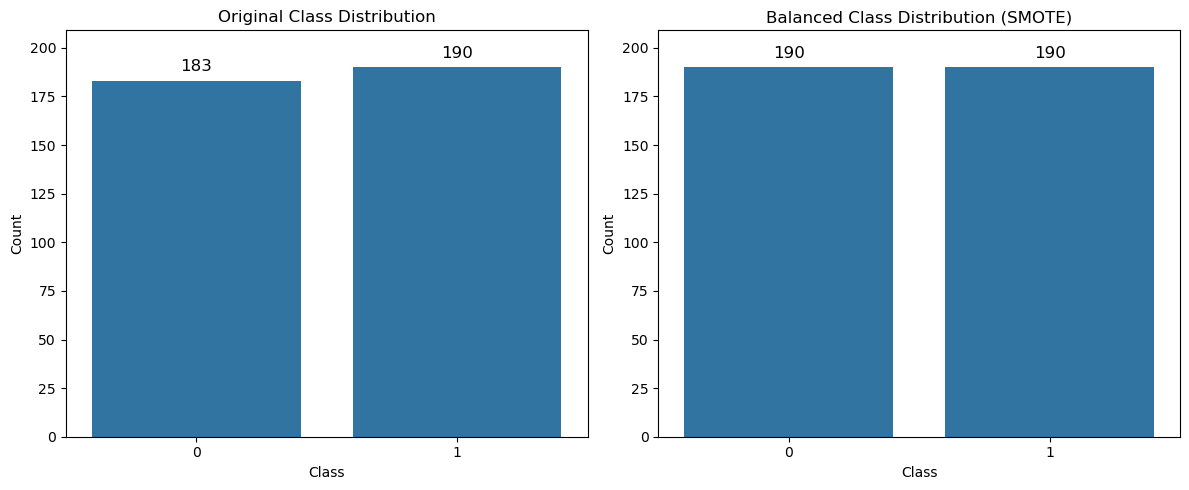

In [ ]:
#counting original class distribution
original_distribution = Counter(y)
# print("Original class distribution:", original_distribution)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
y_resampled = pd.Series(y_resampled)

#counting the new class distribution
balanced_distribution = Counter(y_resampled)
# print("Balanced class distribution:", balanced_distribution)

#creating the plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#creating the original distribution chart
sns.barplot(x=list(original_distribution.keys()), y=list(original_distribution.values()), ax=ax[0])
ax[0].set_title("Original Class Distribution")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Count")
ax[0].set_ylim(0, max(original_distribution.values()) * 1.1)

#annotating the values of the original chart
for p in ax[0].patches:
    ax[0].text(p.get_x() + p.get_width() / 2, p.get_height() + 5,
               f'{int(p.get_height())}', ha='center', fontsize=12)

#creating the balanced distribution chart
sns.barplot(x=list(balanced_distribution.keys()), y=list(balanced_distribution.values()), ax=ax[1])
ax[1].set_title("Balanced Class Distribution (SMOTE)")
ax[1].set_xlabel("Class")
ax[1].set_ylabel("Count")
ax[1].set_ylim(0, max(balanced_distribution.values()) * 1.1)

#annotating the values of the balanced chart
for p in ax[1].patches:
    ax[1].text(p.get_x() + p.get_width() / 2, p.get_height() + 5,
               f'{int(p.get_height())}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
# display(y)
display(y_resampled)

0      1
1      1
2      0
3      0
4      0
      ..
375    0
376    0
377    0
378    0
379    0
Name: Group, Length: 380, dtype: int32

In [ ]:
#this is here to transfer the X
X = X_resampled
y = y_resampled
display(X)
display(y)

,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1,0,1,87,14,2.000000,27.000000,0.000000,1987,0.696000,0.883000
1,2,457,1,88,14,2.000000,30.000000,0.000000,2004,0.681000,0.876000
2,1,0,1,75,12,2.000000,23.000000,0.500000,1678,0.736000,1.046000
3,2,560,1,76,12,2.000000,28.000000,0.500000,1738,0.713000,1.010000
4,3,1895,1,80,12,2.000000,22.000000,0.500000,1698,0.701000,1.034000
...,...,...,...,...,...,...,...,...,...,...,...
375,2,648,1,81,19,1.099975,25.600100,0.500000,1555,0.688401,1.128400
376,2,663,1,73,16,1.000000,24.051738,0.770376,1716,0.698807,1.022245
377,2,1223,1,74,18,2.001126,26.001126,0.500000,1884,0.734331,0.931690
378,1,0,0,85,14,1.285734,29.285666,0.142867,1406,0.715000,1.247714


0      1
1      1
2      0
3      0
4      0
      ..
375    0
376    0
377    0
378    0
379    0
Name: Group, Length: 380, dtype: int32

In [ ]:
print(X.dtypes)  # Check features
print(y.dtypes)  # Check labels

Visit         int64
MR Delay      int64
M/F           int32
Age           int64
EDUC          int64
SES         float64
MMSE        float64
CDR         float64
eTIV          int64
nWBV        float64
ASF         float64
dtype: object
int32


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

futureSample_X = X_test.tail(2)
futureSample_y = y_test.tail(2)

X_test = X_test[:-2]
y_test = y_test[:-2]

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# param_grid = {
#         'n_estimators': [100, 200, 300, 500, 1000],
#         'max_depth': [None, 10, 20, 30, 40, 50],
#         'min_samples_split': [2, 5, 10, 15, 20],
#         'min_samples_leaf': [1, 2, 4, 8],
#         'max_features': ['auto', 'sqrt', 'log2']
#     }

param_grid = {
        'n_estimators': [84],
        'max_depth': [None],
        'min_samples_split': [5],
        'min_samples_leaf': [1],
        'max_features': ['sqrt']
    }

In [ ]:
grid_search = GridSearchCV(estimator=model,
                        param_grid=param_grid,
                        cv=5)  # 5-fold cross-validation
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters: " + str(best_params))

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 84}


In [ ]:
import joblib
joblib.dump(best_model, "rf_alzheimer.pkl")

['rf_alzheimer.pkl']

In [ ]:
y_pred = best_model.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

# X_test = X[:-2]
# y_test = y[:-2]

y_pred = best_model.predict(X_test)
score_test = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {score_test * 100:.2f}%")
report = classification_report(y_test, y_pred)
print('\nClassification Report')
print(report)

y_pred_train = best_model.predict(X_train)
score_test_traint =  accuracy_score(y_train, y_pred_train)
report_train = classification_report(y_train, y_pred_train)
print('\nClassification Report - Trainning Set')
print(report_train)

Accuracy Score: 94.59%

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        40
           1       0.92      0.97      0.94        34

    accuracy                           0.95        74
   macro avg       0.95      0.95      0.95        74
weighted avg       0.95      0.95      0.95        74


Classification Report - Trainning Set
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       148
           1       0.97      0.99      0.98       156

    accuracy                           0.98       304
   macro avg       0.98      0.98      0.98       304
weighted avg       0.98      0.98      0.98       304



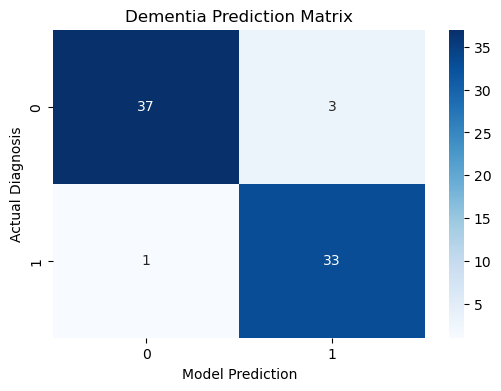

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Model Prediction')
plt.ylabel('Actual Diagnosis')
plt.title('Dementia Prediction Matrix')
plt.show()